In [6]:
## Imports

In [38]:
import pandas as pd
import numpy as np

# data preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# exploratory analysis
import matplotlib.pyplot as plt
#import mlxtend
#from mlxtend.plotting import scatterplotmatrix
#from mlxtend.plotting import heatmap
import seaborn as sns
from IPython.display import Image

# model fit
#import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ignore warnings (libraries are rapidly changing)
import warnings
warnings.filterwarnings('ignore')

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

train = pd.read_csv('train_data.csv')
val = pd.read_csv('val_data.csv')
test = pd.read_csv('test_data.csv')

x_train = train.drop(['average_temperature_°c'], axis=1)
x_val = val.drop(['average_temperature_°c'], axis=1)
x_test = test.drop(['average_temperature_°c'], axis=1)

Y_train = pd.DataFrame(train['average_temperature_°c'])
Y_val = pd.DataFrame(val['average_temperature_°c'])
Y_test = pd.DataFrame(test['average_temperature_°c'])

print(x_train.shape)
print(Y_train.shape)

print(x_val.shape)
print(Y_val.shape)

print(x_test.shape)
print(Y_test.shape)

(4681, 47)
(4681, 1)
(570, 47)
(570, 1)
(570, 47)
(570, 1)


# ________________________________________________________________

# Baseline linear regression model using Stochastic Gradient Descent (SGD) + Sequential

In [21]:
feature = 'total_emission'

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train[[feature]])
x_val_scaled = scaler.transform(x_val[[feature]])
x_test_scaled = scaler.transform(x_test[[feature]])

In [32]:
def build_linear_regression_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1, 
                              input_shape=[1])
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    model.compile(optimizer=optimizer, 
                  loss='mean_absolute_error', 
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

model_linear_regression = build_linear_regression_model()

In [33]:
history = model_linear_regression.fit(x_train_scaled, Y_train, epochs=10, validation_data=(x_val_scaled, Y_val))

Epoch 1/10
147/147 [==============================] - 0s 1ms/step - loss: 0.6695 - root_mean_squared_error: 1.3470 - val_loss: 0.9610 - val_root_mean_squared_error: 1.7254
Epoch 2/10
147/147 [==============================] - 0s 693us/step - loss: 0.5465 - root_mean_squared_error: 1.0162 - val_loss: 0.8180 - val_root_mean_squared_error: 1.3014
Epoch 3/10
147/147 [==============================] - 0s 641us/step - loss: 0.4750 - root_mean_squared_error: 0.7632 - val_loss: 0.7311 - val_root_mean_squared_error: 0.9797
Epoch 4/10
147/147 [==============================] - 0s 661us/step - loss: 0.4204 - root_mean_squared_error: 0.5835 - val_loss: 0.6633 - val_root_mean_squared_error: 0.7826
Epoch 5/10
147/147 [==============================] - 0s 676us/step - loss: 0.3900 - root_mean_squared_error: 0.5112 - val_loss: 0.6458 - val_root_mean_squared_error: 0.7444
Epoch 6/10
147/147 [==============================] - 0s 710us/step - loss: 0.3852 - root_mean_squared_error: 0.5057 - val_loss: 0.6

In [34]:
test_loss, test_rmse = model_linear_regression.evaluate(x_test_scaled, Y_test)
print(f"Test Loss: {test_loss}, Test RMSE: {test_rmse}")

18/18 [==============================] - 0s 644us/step - loss: 0.7584 - root_mean_squared_error: 0.9266
Test Loss: 0.7583654522895813, Test RMSE: 0.9265739917755127


In [35]:
def show_history(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='black')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['root_mean_squared_error'], label='Train RMSE', color='black')
    plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', color='red')
    plt.title('RMSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    plt.show()

    # Printing final values for loss and RMSE
    print('final train mae: {:.3f}'.format(history.history['loss'][-1]))
    print('final val mae:   {:.3f}'.format(history.history['val_loss'][-1]))
    print('final train rmse: {:.3f}'.format(history.history['root_mean_squared_error'][-1]))
    print('final val rmse: {:.3f}'.format(history.history['val_root_mean_squared_error'][-1]))

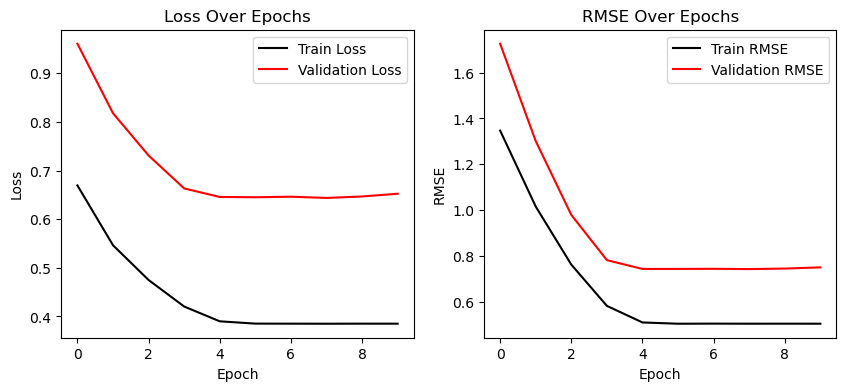

final train mae: 0.385
final val mae:   0.652
final train rmse: 0.506
final val rmse: 0.751
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [36]:
show_history(history)
model_linear_regression.summary()

# Notes on this model: 

- MAE and RMSE are lower for the training set than for the validation set - model might be overfitting? 
- performance drops on the validation set/ low generalizibility to new data 

# ________________________________________________________________

# linear regression model using one-hot encoding, Adam optimizer, two dense layers with 64 neurons each and ReLU activation + output layer with a single neuron

- For numerical data- Fills missing values with the mean and scales data 
- For categorical data-  Fills missing values with the most frequent category and one-hot encoding
- column transformer: Combines the two pipelines into a single preprocessing step. Applies the appropriate preprocessing to each column based on whether it's numerical or categorical

In [40]:
numerical_features = x_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
x_train_prepared = preprocessor.fit_transform(x_train)
x_val_prepared = preprocessor.transform(x_val)
x_test_prepared = preprocessor.transform(x_test)

In [46]:
def build_advanced_model(input_shape):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=[input_shape]),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

In [47]:
input_shape = x_train_prepared.shape[1]

model = build_advanced_model(input_shape)

y_train_np = Y_train.to_numpy()
y_val_np = Y_val.to_numpy()
y_test_np = Y_test.to_numpy()

history = model.fit(x_train_prepared, y_train_np, epochs=10, validation_data=(x_val_prepared, y_val_np))

# Evaluate the model on the test set
test_loss, test_rmse = model.evaluate(x_test_prepared, y_test_np)
print(f'Test Loss: {test_loss}, Test RMSE: {test_rmse}')

Epoch 1/10
147/147 [==============================] - 1s 2ms/step - loss: 0.3613 - root_mean_squared_error: 0.4900 - val_loss: 0.3646 - val_root_mean_squared_error: 0.4985
Epoch 2/10
147/147 [==============================] - 0s 1ms/step - loss: 0.2903 - root_mean_squared_error: 0.4017 - val_loss: 0.3224 - val_root_mean_squared_error: 0.4100
Epoch 3/10
147/147 [==============================] - 0s 1ms/step - loss: 0.2769 - root_mean_squared_error: 0.3870 - val_loss: 0.3130 - val_root_mean_squared_error: 0.3974
Epoch 4/10
147/147 [==============================] - 0s 1ms/step - loss: 0.2648 - root_mean_squared_error: 0.3755 - val_loss: 0.3311 - val_root_mean_squared_error: 0.4126
Epoch 5/10
147/147 [==============================] - 0s 1ms/step - loss: 0.2597 - root_mean_squared_error: 0.3703 - val_loss: 0.3083 - val_root_mean_squared_error: 0.3867
Epoch 6/10
147/147 [==============================] - 0s 1ms/step - loss: 0.2536 - root_mean_squared_error: 0.3635 - val_loss: 0.3283 - val_

# Notes on the model

- more accurate on the training set than on the validation set = better than baseline
- still some possible overfitting due to both MAE and RMSE are higher for val set

# ________________________________________________________________

# Feed-Forward Neural Network (FFNN) with one hidden layer and embeddings 

In [67]:
categorical_features = ['sub-region', 'area'] 

for feature in categorical_features:
    x_train[feature], uniques = pd.factorize(x_train[feature])
    x_val[feature] = uniques.get_indexer(x_val[feature])
    x_test[feature] = uniques.get_indexer(x_test[feature])
    
for column in x_train.columns:
    if x_train[column].dtype == 'object':
        x_train[column], _ = pd.factorize(x_train[column])
        x_val[column] = uniques.get_indexer(x_val[column])
        x_test[column] = uniques.get_indexer(x_test[column])

In [53]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

In [54]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, concatenate
from tensorflow.keras.models import Model

# Define input layers
numerical_input = Input(shape=(len(numerical_features),))
sub_region_input = Input(shape=(1,))
area_input = Input(shape=(1,))

# Embedding layers
sub_region_embedding = Embedding(input_dim=x_train['sub-region'].nunique(), output_dim=10)(sub_region_input)
area_embedding = Embedding(input_dim=x_train['area'].nunique(), output_dim=10)(area_input)
sub_region_flat = Flatten()(sub_region_embedding)
area_flat = Flatten()(area_embedding)

# Concatenate all inputs
concat_inputs = concatenate([numerical_input, sub_region_flat, area_flat])

# Hidden layer
hidden = Dense(128, activation='relu')(concat_inputs)

# Output layer
output = Dense(1)(hidden)

# Create and compile model
model = Model(inputs=[numerical_input, sub_region_input, area_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        170         ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        1900        ['input_3[0][0]']                
                                                                                              

In [55]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [66]:
train_data = [x_train[numerical_features], x_train['sub-region'], x_train['area']]
val_data = [x_val[numerical_features], x_val['sub-region'], x_val['area']]

history = model.fit(train_data, Y_train, epochs=10, validation_data=(val_data, Y_val))

Epoch 1/10
147/147 [==============================] - 0s 1ms/step - loss: 0.1512 - val_loss: 0.1682
Epoch 2/10
147/147 [==============================] - 0s 902us/step - loss: 0.1454 - val_loss: 0.1643
Epoch 3/10
147/147 [==============================] - 0s 908us/step - loss: 0.1477 - val_loss: 0.1272
Epoch 4/10
147/147 [==============================] - 0s 881us/step - loss: 0.1483 - val_loss: 0.1812
Epoch 5/10
147/147 [==============================] - 0s 887us/step - loss: 0.1484 - val_loss: 0.1052
Epoch 6/10
147/147 [==============================] - 0s 854us/step - loss: 0.1509 - val_loss: 0.1701
Epoch 7/10
147/147 [==============================] - 0s 912us/step - loss: 0.1488 - val_loss: 0.0929
Epoch 8/10
147/147 [==============================] - 0s 941us/step - loss: 0.1437 - val_loss: 0.1517
Epoch 9/10
147/147 [==============================] - 0s 927us/step - loss: 0.1470 - val_loss: 0.1332
Epoch 10/10
147/147 [==============================] - 0s 921us/step - loss: 0.1528 

In [62]:
test_data = [x_test[numerical_features], x_test['sub-region'], x_test['area']]
test_loss = model.evaluate(test_data, Y_test)
print(f"Test Loss: {test_loss}")

18/18 [==============================] - 0s 621us/step - loss: 0.2429
Test Loss: 0.24293681979179382


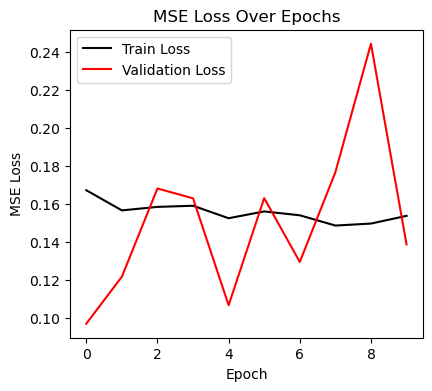

final train MSE: 0.154
final val MSE:   0.139
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        170         ['input_2[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        1900        ['input_3[0][0]']                
                                                

In [65]:
def show_history(history):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color='black')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('MSE Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    
    plt.show()

    print('final train MSE: {:.3f}'.format(history.history['loss'][-1]))
    print('final val MSE:   {:.3f}'.format(history.history['val_loss'][-1]))


show_history(history)
model.summary()

# Notes again 

- model is not overfitting the training data (good!)
- Both MSE values are relatively low- model is performing well 